                 open       high   low  close  adj close    volume  證券代號 股票名稱  \
2023-12-13  31.799999  31.950001  31.5  31.65      31.65  47734606  2618  長榮航   
2023-12-14  31.799999  32.049999  31.6  31.75      31.75  51349526  2618  長榮航   

            融資買進  融資賣出  ...  融資今日餘額     融資限額  融券買進  融券賣出  融券現券償還  融券前日餘額  \
2023-12-13  3697  7769  ...  141123  1350111    92    37       0    3132   
2023-12-14  3971  4166  ...  140923  1350111    26   189       0    3077   

            融券今日餘額     融券限額  資券互抵  註記  
2023-12-13    3077  1350111    24      
2023-12-14    3240  1350111    36      

[2 rows x 22 columns]
                 open       high   low  close  adj close    volume  證券代號 股票名稱  \
2023-12-13  31.799999  31.950001  31.5  31.65      31.65  47734606  2618  長榮航   
2023-12-14  31.799999  32.049999  31.6  31.75      31.75  51349526  2618  長榮航   

            融資買進  融資賣出  ...     融資限額  融券買進  融券賣出  融券現券償還  融券前日餘額  融券今日餘額  \
2023-12-13  3697  7769  ...  1350111    92    37       0    3132

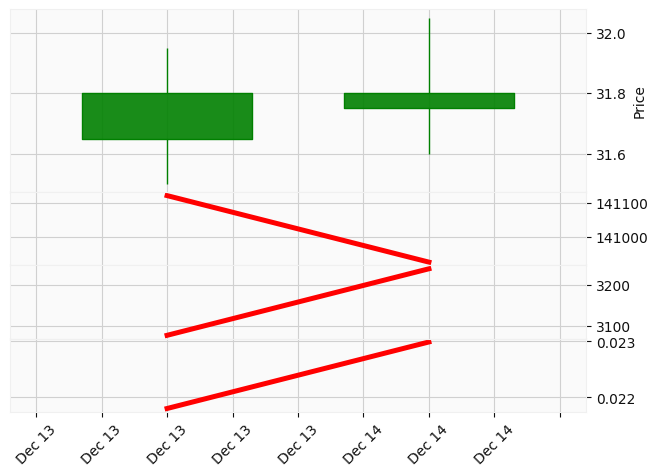

In [1]:
# 載入必要套件
from BackTest import ChartTrade
import mplfinance as mpf
import pandas as pd
import os
import yfinance as yf


# 設定在根目錄即可，之後可以改到 /data
datapath = "./"


# 更新資料源為 yahoo finance
def getDataFM(prod, st, en):
    #
    bakfile = f"data//YF_{prod}_{st}_{en}_stock_daily_adj.csv"
    if os.path.exists(bakfile):
        data = pd.read_csv(bakfile, index_col="Date", parse_dates=True)
    else:
        data = yf.download(f"{prod}.TW", start=st, end=en)
        data.columns = [i.lower() for i in data.columns]
        # 除錯 如果沒有資料
        if data.empty:
            print("沒有資料")
            return pd.DataFrame()
        # 將資料寫入備份檔
        data.to_csv(bakfile)
    return data


# 取得股價以及融資融券 證交所資料來源
def getTSEPriceAndMarginTrade(prod, st, en):
    data1 = getDataFM(prod, st, en)
    # 取得證交所的融資融券
    data2 = getTSEMarginTrading(prod, st, en)
    data3 = pd.concat([data1, data2], axis=1, join="inner")
    return data3


# 取得融資融券 證交所資料來源
def getTSEMarginTrading(prod, st, en):
    # 檔案名稱
    bakfile = f"{datapath}/{prod}_{st}_{en}_TSE_MarginTrading.csv"
    # 假如檔案已經存在
    if os.path.exists(bakfile):
        tmpdata = pd.read_csv(bakfile, index_col="日期", parse_dates=True)
    # 沒有的就儲存檔案
    else:
        # 取得檔案內容
        tmpdata = pd.read_csv("融資融券爬蟲資料.csv", encoding="utf-8")
        # 修改日期格式
        tmpdata["日期"] = pd.to_datetime(tmpdata["日期"].astype(str), format="%Y%m%d")
        # 使用正确的日期比较
        tmpdata = tmpdata.query("`證券代號` == @prod and @st <= `日期` <= @en")
        #
        tmpdata["日期"] = pd.to_datetime(tmpdata["日期"], format="%Y%m%d")
        tmpdata.set_index("日期", inplace=True)
        # 將資料內容轉換為數值
        for col in tmpdata.columns[2:-1]:
            tmpdata[col] = tmpdata[col].str.replace(",", "").astype(int)
        # 將單一證券內容寫入備份檔中
        tmpdata.to_csv(bakfile)
    # 回傳資料：加入這部分可確保讀取正確，之後可透過標準化來處理這個轉換
    tmpdata.columns = [
        "證券代號",
        "股票名稱",
        "融資買進",
        "融資賣出",
        "融資現金償還",
        "融資前日餘額",
        "融資今日餘額",
        "融資限額",
        "融券買進",
        "融券賣出",
        "融券現券償還",
        "融券前日餘額",
        "融券今日餘額",
        "融券限額",
        "資券互抵",
        "註記",
    ]
    return tmpdata


# 取得回測資料
# 這裡之後要加入防呆
prod = "2618"
data = getTSEPriceAndMarginTrade(prod, "2023-12-13", "2023-12-15")
# 這是查看欄位名稱使用
# print(data.columns)
print(data.head(10))
# 融資融券餘額
data["融券今日餘額"] = data["融券今日餘額"].astype(int)
data["融資今日餘額"] = data["融資今日餘額"].astype(int)

# 計算券資比
data["券資比"] = data["融券今日餘額"] / data["融資今日餘額"]

print(data.head(10))

# 繪製副圖
addp = []
# 融資融券
addp.append(mpf.make_addplot(data["融資今日餘額"], panel=1, color="red", secondary_y=False))
addp.append(mpf.make_addplot(data["融券今日餘額"], panel=2, color="red", secondary_y=False))
addp.append(mpf.make_addplot(data["券資比"], panel=3, color="red", secondary_y=False))

# 繪製K線圖與交易明細
ChartTrade(data, addp=addp, v_enable=False)
